Load modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import datetime
from pathlib import Path
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#settings
#plt.rc('font', size=14) 

Load data

In [32]:
path = Path(r'/Users/sr2/OneDrive - University College London/PhD/Research/'
        'Missions/SWARM/Non-Flight Data/Analysis/Apr-22/data/processing/remove_outliers/')

#filename = str(path) + '/15-17-19-21_outliers.csv'
filename = str(path) + '/15-21_all-mons_outliers.csv'
df = pd.read_csv(filename)
df = df.sort_values(by=['Timestamp'], ascending = True)
#df = df.iloc[::6] #set resolution
df.shape

(3182307, 25)

Replace -1 with 0, otherwise its a non-binary problem

In [33]:
df=df.replace({'b_ind': -1}, 0)
df.dtypes


Timestamp     object
lat          float64
alt          float64
o_num          int64
abc           object
Ne           float64
Ne_rod       float64
Ne_rod20     float64
Ne_del10     float64
Ne_del40     float64
Te           float64
pot          float64
bf_iono      float64
b_ind          int64
b_prob       float64
Kp           float64
Dst          float64
F107         float64
sza          float64
y_sin        float64
y_cos        float64
mlt_sin      float64
mlt_cos      float64
lon_sin      float64
lon_cos      float64
dtype: object

Remove n/a and non-useful features. This could be elsewhere

In [19]:
#df = df[['Timestamp','mlt_sin','mlt_cos','y_sin','y_cos','lon_sin','lon_cos','bf_iono','Ne','Ne_rod','Ne_del10','Kp','F107','b_ind']]

In [34]:
df=df.dropna()
df = df.sort_values(by=['Timestamp'], ascending = True)
time = df.pop('Timestamp')
abc = df.pop('abc')
lat = df.pop('lat')
b_prob = df.pop('b_prob')
alt = df.pop('alt')


In [31]:
df = df[df['Time']]
print (check_for_nan)

0          False
1          False
2          False
3          False
4          False
           ...  
3182302     True
3182303     True
3182304     True
3182305     True
3182306     True
Name: bf_iono, Length: 3182307, dtype: bool


Split and normalise the data

In [35]:
#split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

print ('\n'.join([
    f'Train set size: {len(train_df)}',
    f'Val set size: {len(val_df)}',
    f'Test set size: {len(test_df)}',
    ]))

num_features = df.shape[1]

'''
#norm for std and mean
train_mean = train_df.mean()
train_std = train_df.std()

#Must always use train_mean & train_std so model cannot see any of these vals
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
'''

#for 0-1
train_max = train_df.max()
train_min = train_df.min()

train_df = (train_df-train_min) / (train_max-train_min)
val_df = (val_df-train_min) / (train_max-train_min)
test_df = (test_df-train_min) / (train_max-train_min)


Train set size: 1284220
Val set size: 366920
Test set size: 183460


Visualise the distribution

In [ ]:
'''
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(15, 5), dpi=50)
ax = sns.boxplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)'''

In [ ]:
'''
df_corr = df.corr()
plt.figure(figsize=(15,9), dpi=100)
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, center=0, mask=mask, cbar_kws={"shrink": .7},
        square=False, linewidths=0.5, annot=True, fmt=".1f")'''

Select the feature to run

In [36]:
feat_to_fore = 'b_ind'

Data windowing

In [37]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


        

Split the data into a window of inputs (n) and labels (y)

In [41]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :] #-1 remove b_ind
  labels = features[:, self.labels_slice, :]

  labels = tf.stack([labels[:, :, self.column_indices[name]] 
      for name in self.label_columns],axis=-1) #negative values wrap around

  #Force update the shape of the tensor
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])


  return inputs, labels

#add to class
WindowGenerator.split_window = split_window

Create an example window and plot

In [42]:
#Example plot

OUT = 45
eg_plot = WindowGenerator(input_width=90, label_width=45, shift=45,
                     label_columns=[feat_to_fore])
end_index = eg_plot.total_window_size

#Example plots for testing the plotting function
example_window = tf.stack([np.array(train_df[:end_index]),
                           np.array(train_df[5100:5100+end_index]),
                           np.array(train_df[1300:1300+end_index]),
                           np.array(train_df[2500:2500+end_index]),
                           np.array(train_df[3700:3700+end_index]),
                           np.array(train_df[4900:4900+end_index]),
                           ])

example_inputs, example_labels = eg_plot.split_window(example_window)


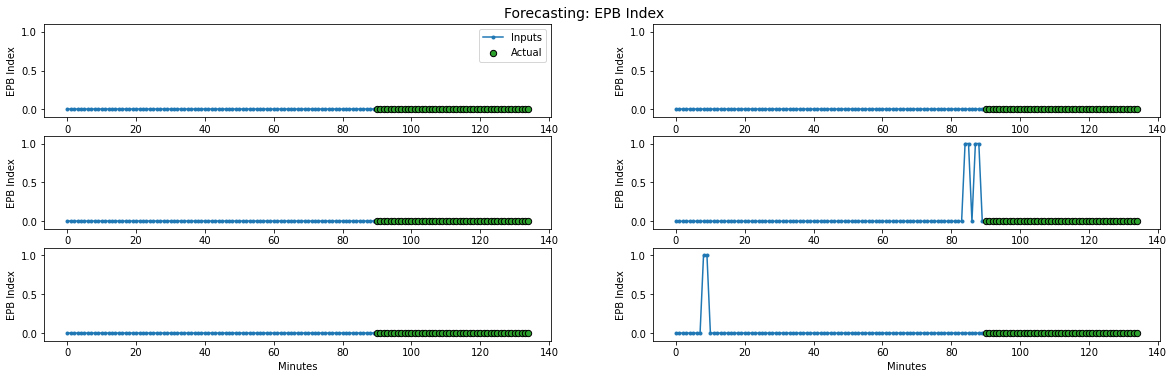

In [43]:
eg_plot.example = example_inputs, example_labels

def plot(self, model=None, plot_col=feat_to_fore , subplot_num=6, cad=1, skip=1):
   
  inputs, labels = self.example

  plt.figure(figsize=(20, 12))
  
  plot_col_index = self.column_indices[plot_col]

  #Extract the mean and stddev values for un-norming 
  #stddev = train_std[plot_col_index]
  #mean = train_mean[plot_col_index]

  for n in range(subplot_num):
    plt.suptitle(f'Forecasting: EPB Index', y = 0.9, va='top', fontsize=14)
    plt.subplot(subplot_num, 2, n+1)

    plt.ylabel(f'EPB Index')
    
    #The inputs
    un_norm_inputs = inputs[n,:,plot_col_index]
    #un_norm_inputs = (un_norm_inputs * stddev) + mean

    plt.plot((self.input_indices*cad)[::skip], un_norm_inputs[::skip],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    
    #The actual reading
    un_norm_labels = labels[n, :, label_col_index]
    #un_norm_labels = (un_norm_labels * stddev) + mean

    plt.scatter((self.label_indices*cad)[::skip], un_norm_labels[::skip],
                edgecolors='k', label='Actual', c='#2ca02c', s=40)
    
    #The forecast
    if model is not None:
      predictions = model(inputs)
      un_norm_preds = predictions[n, :, label_col_index]
      #un_norm_preds = (un_norm_preds * stddev) + mean
      plt.rc('font', size=13) 
      plt.scatter((self.label_indices*cad)[::skip], un_norm_preds[::skip],
                  marker='X', edgecolors='k', label='Forecast',
                  c='#ff7f0e', s=40)

    plt.ylim([-0.1,1.1])
    plt.xlabel('Minutes')
    if n == 0:
      plt.legend()
      #plt.tight_layout()


WindowGenerator.plot = plot
eg_plot.plot()


Convert the data into a tensorflow time series

In [44]:
def make_dataset(self, data, batch_size=32):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=45, #change this to orbit index
      shuffle=True,
      batch_size=batch_size,) 

  ds = ds.map(self.split_window) #excecutes a function for each iterable item

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = next(iter(self.train))
  self._example = result
  return result

'''
@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result'''

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
'''
#inspect the elements in the new dataset format
eg_plot.test.element_spec

for example_inputs, example_labels in eg_plot.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')'''

Create a window for modelling and one for plotting

In [39]:
#shift = how far into the future

OUT_STEPS = 90

run_window = WindowGenerator(
    input_width=90, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=[feat_to_fore])

run the model

In [88]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

MAX_EPOCHS = 1

def compile_and_fit(model, window, patience=1):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(
                #loss=tf.losses.MeanSquaredError(),
                loss = tf.losses.BinaryCrossentropy(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001), #default = 0.001
                metrics=[tf.metrics.MeanAbsoluteError()])
                #metrics=[tf.metrics.AUC(curve='pr')])

  print(model.summary())

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=True),
    #LSTM(8, return_sequences=True),

    #Dropout(rate = .3),
    Dense(units=1, activation='softmax')
  
])

'''
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])'''

#print('Input shape:', run_window.example[0].shape)
#print('Output shape:', lstm_model(run_window.example[0]).shape)

lstm_model(run_window.example[0]).shape
print('Input shape:', run_window.example[0].shape)

history = compile_and_fit(lstm_model, run_window)
#IPython.display.clear_output()

Input shape: (32, 90, 20)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (32, 90, 32)              6784      
                                                                 
 lstm_5 (LSTM)               (32, 90, 16)              3136      
                                                                 
 dense_2 (Dense)             (32, 90, 1)               17        
                                                                 
Total params: 9,937
Trainable params: 9,937
Non-trainable params: 0
_________________________________________________________________
None
892/892 [==============================] - 43s 44ms/step - loss: 0.0333 - mean_absolute_error: 0.9973 - val_loss: 0.0083 - val_mean_absolute_error: 0.9992


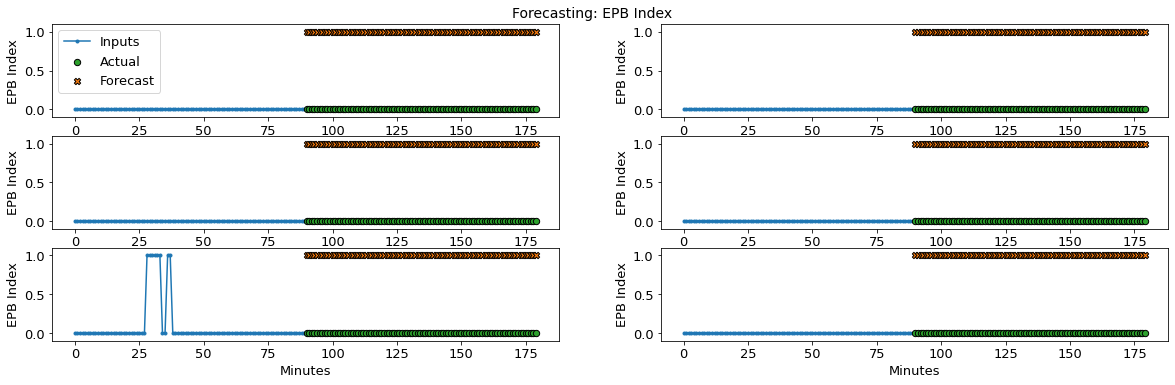

In [94]:
figure = run_window.plot(lstm_model)

In [ ]:
per = history.history
loss = per['loss']
#mae = per['mean_absolute_error']
vloss = per['val_loss']
#vmae = per['val_mean_absolute_error']

x = np.arange(len(loss))
plt.title(f"Forecasting {feat_to_fore}", fontsize=14)
sns.lineplot(x=x, y=loss, label="loss")
sns.lineplot(x=x, y=vloss, label = "val loss")

plt.xlabel('epoch')
plt.ylabel('loss')


In [ ]:
x = np.arange(len(loss))
sns.lineplot(x=x, y=mae, label="mae")
sns.lineplot(x=x, y=vmae, label ="vmae")

plt.title(f"Forecasting {feat_to_fore}", fontsize=14)
plt.xlabel('epoch')
plt.ylabel('mean sqaure error')

Simple model

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices[feat_to_fore])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Persistence'] = baseline.evaluate(run_window.val)
performance['Persistence'] = baseline.evaluate(run_window.test, verbose=0)

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Persistence'] = repeat_baseline.evaluate(run_window.val)
performance['Persistence'] = repeat_baseline.evaluate(run_window.test, verbose=0)
run_window.plot(repeat_baseline)

In [ ]:
plot_window.plot(baseline)

Conv Model

In [ ]:
CONV_WIDTH = 90
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=45,
    shift=45,
    label_columns=[feat_to_fore])

conv_window

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

history = compile_and_fit(conv_model, conv_window)

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(run_window.val)
performance['Conv'] = conv_model.evaluate(run_window.test, verbose=0)

Get LSTM performance scores

In [ ]:

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(run_window.val)
performance['Conv'] = conv_model.evaluate(run_window.test, verbose=0)

In [ ]:
val_performance['LSTM'] = lstm_model.evaluate(run_window.val)
performance['LSTM'] = lstm_model.evaluate(run_window.test, verbose=0)

Compare the performance of the different models

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.figure(figsize=(5,3), dpi=100)
plt.ylabel(f'mean absolute error [{feat_to_fore}]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=0)
_ = plt.legend(loc="lower right")

In [ ]:
import shap
#explainer = shap.DeepExplainer(lstm_model, X_train)

mod_in = lstm_model.layers[0].input
mod_out = lstm_model.layers[-1].output
print(mod_out)

X_train = np.array(run_window.train)
print(X_train)
#explainer = shap.DeepExplainer((mod_in, mod_out), X_train)

# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
#shap_values = explainer.shap_values(X_test)
# init the JS visualization code
#shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)